- competition/dataset : [https://www.kaggle.com/c/nyc-taxi-trip-duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)
- date : 2021/02/25
- original : [https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse](https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse)

## EDA + Baseline Model

**✏ 필사 1회** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test.shape

(625134, 9)

### Convert to appropriate datetype

In [3]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


### Are there any missing values in the data?
결측값 유무

In [4]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

결측값은 없습니다.

### What is the time period of the dataset?
데이터셋의 전체 기간

In [5]:
print('Min pickup time:', min(train['pickup_datetime']))
print('Max pickup time:', max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


데이터는 1월부터 6월까지 6개월 가량의 택시 이동 데이터입니다.

### Create new day, month, hour info from pickup and dropoff time
pickup과 dropoff 시간으로 부터 새로운 day, month, hour 정보 생성

In [6]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].dt.day
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

### Round lat lon to 3 decimal places
경도와 위도를 소숫점 세 자리로 반올림

In [7]:
train['pickup_latitude_round3'] = round(train['pickup_latitude'], 3)
train['pickup_longitude_round3'] = round(train['pickup_longitude'], 3)
train['dropoff_latitude_round3'] = round(train['dropoff_latitude'], 3)
train['dropoff_longitude_round3'] = round(train['dropoff_longitude'], 3)

train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005


### Based on Latitude and Longitude get the distance of the trip in km
위도와 경도를 기반으로 km 단위의 이동 거리 계산  
여기서는 하버사인 거리를 사용합니다.

In [8]:
def calculateDistance(row):
    R = 6373
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat/2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

In [9]:
train['trip_distance'] = train.apply(lambda x: calculateDistance(x), axis=1)
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103


In [10]:
train['trip_duration_in_hour'] = train['trip_duration'] / 3600
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000


### Exploratory Analysis

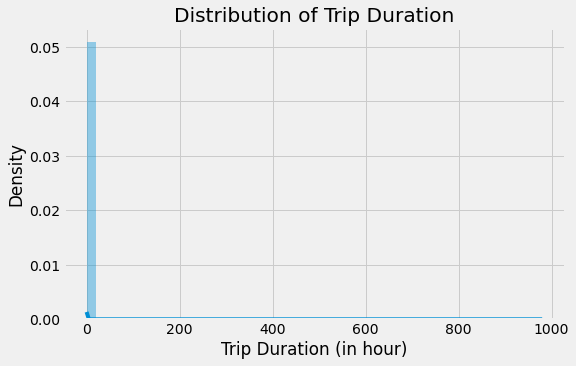

In [11]:
# 이동 시간 히스토그램
plt.figure(figsize=(8, 5))
sns.distplot(train['trip_duration_in_hour'])
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (in hour)')
plt.show()

주행 시간이 24시간 이상인 데이터들이 있습니다. 이것은 사용해야 할까요?

In [12]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


이 네 개의 기록은 이상값으로, 이동 시간은 굉장히 길지만 이동 거리는 매우 짧습니다. 그러나 이동 시작점이나 끝점이 정해져있나요? 이동 시간 또한 왜곡되어 있으므로 로그 변환을 취해보겠습니다.

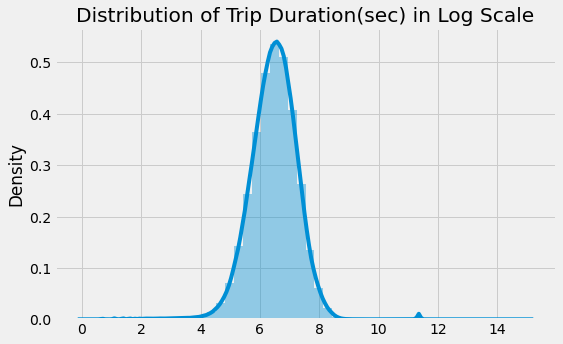

In [13]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log(train['trip_duration'].values))
plt.title('Distribution of Trip Duration(sec) in Log Scale')
plt.show()

이동 거리의 로그 변환은 정규 분포를 따르며, 대부분의 이동은 54초(exp(4))와 2980초(exp(8)) 사이입니다. 이것은 대부분의 여행이 한 시간 이내임을 나타내며, 1분 이내의 이동에 대해서는 자세히 연구해볼 필요가 있습니다. 또한 100시간 이상 지속되는 여행들도 있는데, 택시 승차는 뉴욕 안에서 일어났기 때문에 약간 이상합니다.

#### Heatmap of common locations from where pickup and dropoff occurs
pickup과 dropoff가 발생하는 공통 지역들에 대한 히트맵

In [14]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [15]:
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
hm_wide = HeatMap(
    list(zip(pickup['pickup_latitude_round3'].values, pickup['pickup_longitude_round3'].values, np.array(pickup['Num_Trips'].values).astype('float64'))),
    min_opacity=0.5, radius=8, blur=15, max_zoom=1
)
pickup_map.add_child(hm_wide)
pickup_map

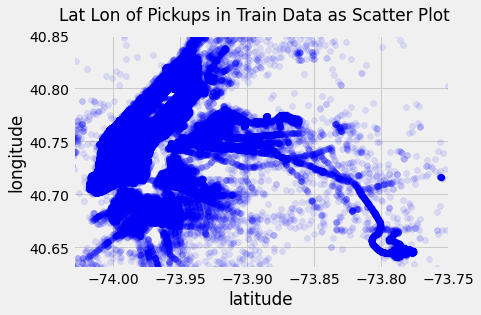

In [16]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           color='blue', label='train', alpha=0.1)
fig.suptitle('Lat Lon of Pickups in Train Data as Scatter Plot')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

In [17]:
dropoff = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [18]:
dropoff_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
hm_wide = HeatMap(
    list(zip(dropoff['dropoff_latitude_round3'].values, dropoff['dropoff_longitude_round3'].values, np.array(dropoff['Num_Trips'].values).astype('float64'))),
    min_opacity=0.5, radius=8, blur=15, max_zoom=1
)
dropoff_map.add_child(hm_wide)
dropoff_map

pickup과 dropoff의 히트맵이 유사한 패턴을 보입니다.

### Heatmap of trip duration, when pickup originates from a point
pickup 포인트에 나타낸 이동 시간 히트맵

In [19]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'Avg_Trip_duration'})

In [20]:
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
hm_wide = HeatMap(
    list(zip(pickup['pickup_latitude_round3'].values, pickup['pickup_longitude_round3'].values, np.array(pickup['Avg_Trip_duration']).astype('float64'))),
    min_opacity=0.5, radius=11, blur=15, max_zoom=1
)
pickup_map.add_child(hm_wide)
pickup_map

JFK에서 출발한 경우의 평균 주행 시간이 가장 높습니다. 확대해보면, 그 다음으로 manhattan이 높은 것을 확인할 수 있습니다.

### Which hours are pickup and dropoff higher?
어느 시간대에 pickup과 dropoff가 많을까요?

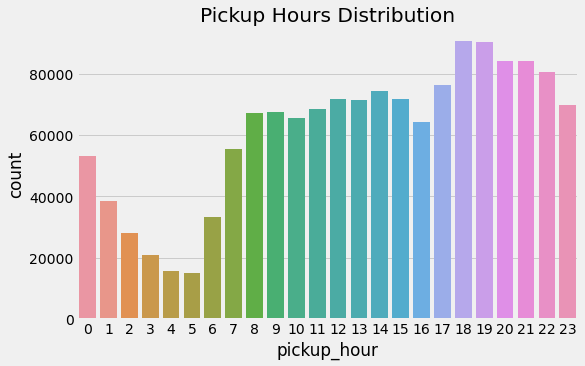

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['pickup_hour'])
plt.title('Pickup Hours Distribution')
plt.show()

pickup은 이른 아침일수록 줄어듭니다. 가장 활발한 시간대는 오후 6-8시 사이입니다.

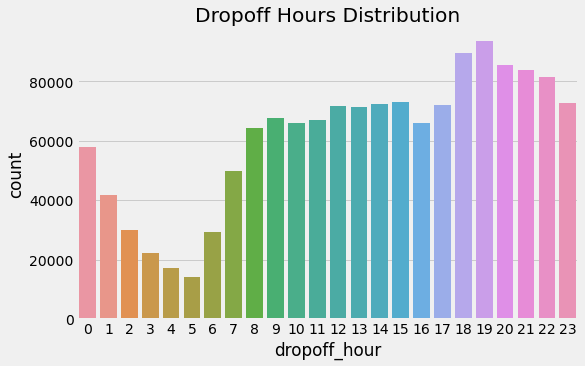

In [22]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['dropoff_hour'])
plt.title('Dropoff Hours Distribution')
plt.show()

dropoff도 pickup과 양상이 비슷합니다.

### Pickup over the entire time period
전체 기간의 pickup 수

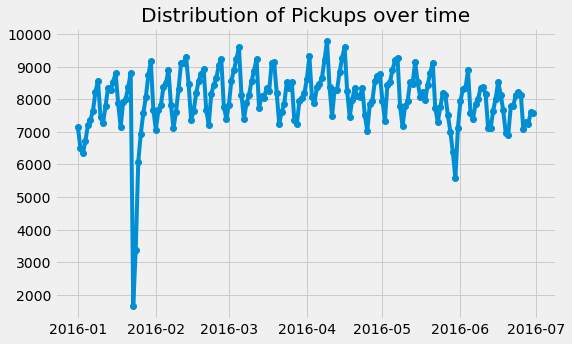

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title('Distribution of Pickups over time')
plt.show()

2016년 1월에 pickup 수가 급감합니다.

### What is the distribution of trip distance
이동 거리의 분포

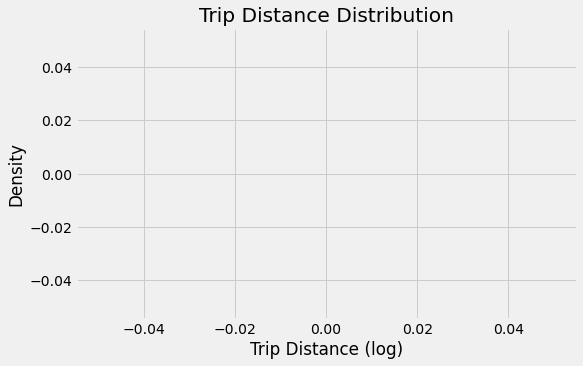

In [24]:
plt.figure(figsize=(8, 5))
sns.kdeplot(np.log(train['trip_distance'].values))
plt.title('Trip Distance Distribution')
plt.xlabel('Trip Distance (log)')
plt.show()

### Trip Duration vs. Trip Distance
이동 시간 vs. 이동 거리

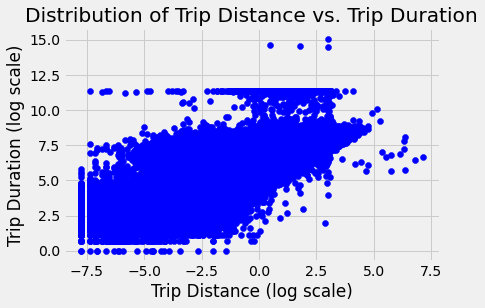

In [25]:
plt.scatter(
    np.log(train['trip_distance'].values), np.log(train['trip_duration'].values),
    color='blue', label='train'
)
plt.title('Distribution of Trip Distance vs. Trip Duration')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Trip Duration (log scale)')
plt.show()

### Is the trip duration higher at different hours?
시간대별 이동 시간

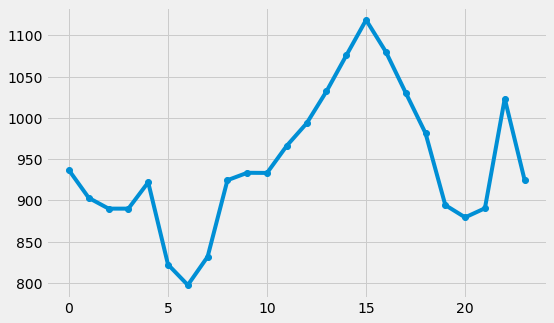

In [26]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean()
plt.figure(figsize=(8, 5))
plt.plot(avg_duration_hour, 'o-')
plt.show()

이동 시간은 10-15시에 증가합니다.

### Distribution of Pickups across Days
요일별 pickup 분포

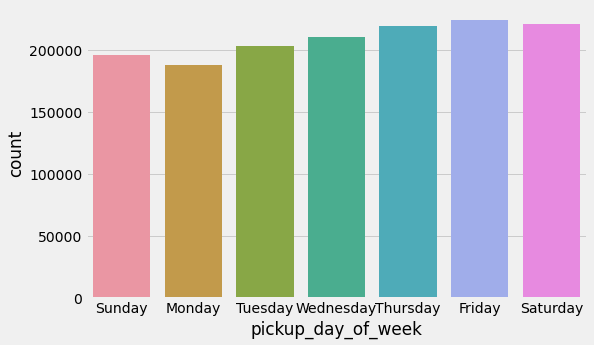

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(train['pickup_day_of_week'], order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

pickup 수는 월요일에 가장 낮고 금요일에 가장 높습니다.

### Avg Trip Duration over Days of week
요일별 평균 이동 시간

In [28]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})

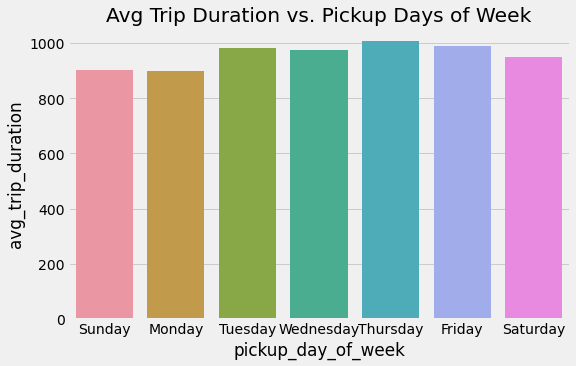

In [29]:
plt.figure(figsize=(8, 5))
sns.barplot(
    'pickup_day_of_week', 'avg_trip_duration', data=avg_duration_day,
    order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
)
plt.title('Avg Trip Duration vs. Pickup Days of Week')
plt.show()

평균적으로 목요일이 가장 깁니다.

### Create a calculated field Bearing
방위(bearing)는 주행 방향을 측정합니다.  
$$ \theta = arctan2(sin\Delta{\lambda} \cdot cos\phi2,\, cos\phi1 \cdot sin\phi2 - sin\phi1 \cdot cos\phi2 \cdot cos\Delta\lambda)$$  
$\lambda$: 경도  
$\phi$: 위도

In [30]:
def calculateBearing(lat1, lon1, lat2, lon2):
    R = 6371
    lon_delta_rad = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [31]:
train['bearing'] = calculateBearing(train['pickup_latitude_round3'], train['pickup_longitude_round3'], train['dropoff_latitude_round3'], train['dropoff_longitude_round3'])

### Distribution of Bearing
방위의 분포

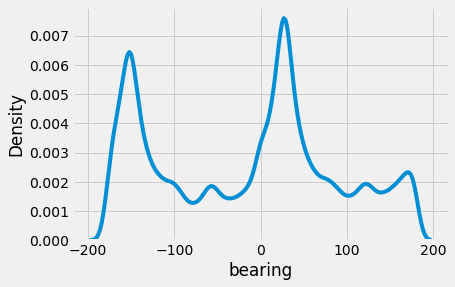

In [32]:
sns.kdeplot(train['bearing'])
plt.show()

### Bearing vs. Trip Duration
방위 vs. 이동 시간

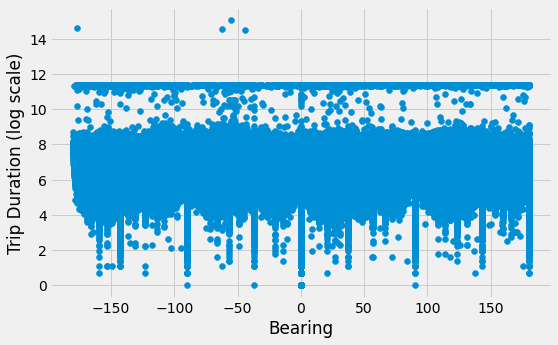

In [33]:
plt.figure(figsize=(8, 5))
plt.scatter(train['bearing'], np.log(train['trip_duration'].values))
plt.xlabel('Bearing')
plt.ylabel('Trip Duration (log scale)')
plt.show()

방위가 약 -50도인 지점에서 이동 기간에 대한 이상치가 존재합니다.

### Distribution of Store and FWD Flag
store_and_fwd_flag 분포

In [34]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

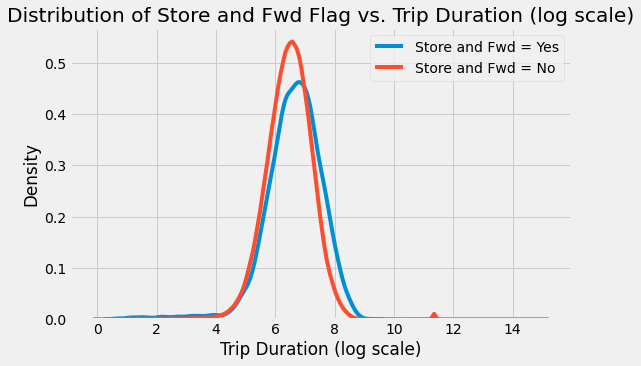

In [35]:
plt.figure(figsize=(8, 5))
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='Y', 'trip_duration'].values), label='Store and Fwd = Yes')
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag']=='N', 'trip_duration'].values), label='Store and Fwd = No')
plt.title('Distribution of Store and Fwd Flag vs. Trip Duration (log scale)')
plt.xlabel('Trip Duration (log scale)')
plt.ylabel('Density')
plt.legend()
plt.show()

### Group Locations into cluster
클러스터로 그룹화  
이것은 이웃을 형성하는데 도움을 줄 것이며, 특정 이웃의 pickup은 더 긴 이동 시간을 가질 것입니다.

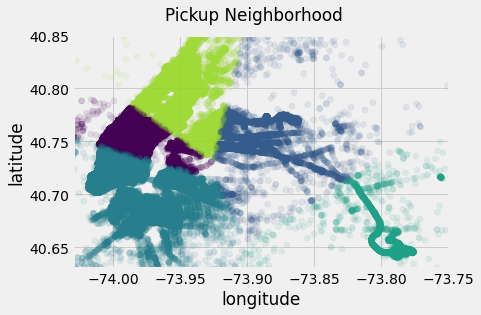

In [36]:
coords = np.vstack((
    train[['pickup_latitude', 'pickup_longitude']].values,
    train[['dropoff_latitude', 'dropoff_longitude']].values,
    test[['pickup_latitude', 'pickup_longitude']].values,
    test[['dropoff_latitude', 'dropoff_longitude']].values
))
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)
train['pickup_neighborhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_neighborhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'],
           c=train['pickup_neighborhood'], label='train', alpha=0.1)
fig.suptitle('Pickup Neighborhood')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

### Number of pickups in each neighborhood
각 이웃의 pickup 수

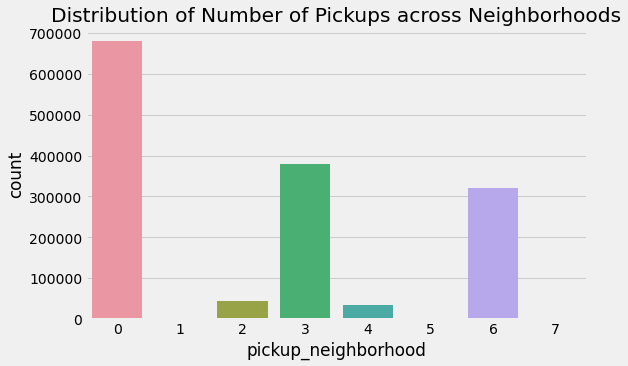

In [37]:
plt.figure(figsize=(8, 5))
sns.countplot(train['pickup_neighborhood'])
plt.title('Distribution of Number of Pickups across Neighborhoods')
plt.show()

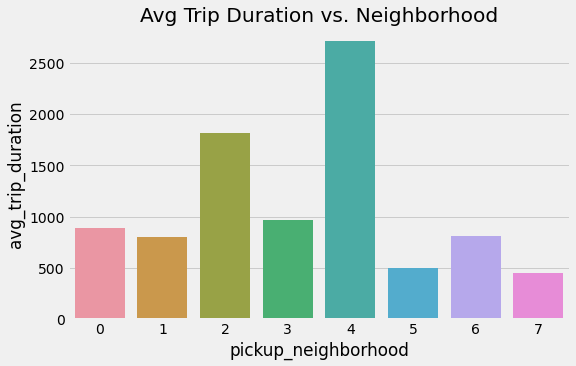

In [38]:
avg_duration_neighborhood = train.groupby(['pickup_neighborhood'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8, 5))
sns.barplot('pickup_neighborhood', 'avg_trip_duration', data=avg_duration_neighborhood)
plt.title('Avg Trip Duration vs. Neighborhood')
plt.show()

neighborhood 2의 평균 이동 시간이 매우 길지만 0은 pickup의 대부분을 가지고 있습니다.

### Distribution of Average speed
평균 속도의 분포

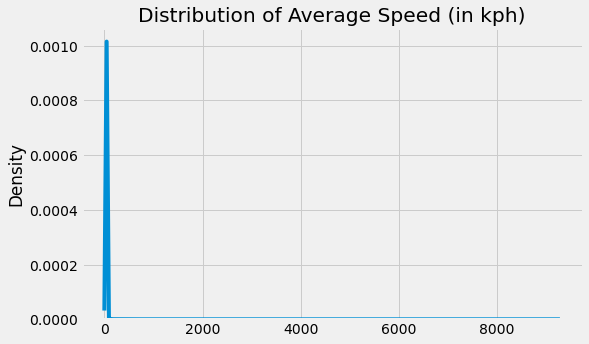

In [39]:
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']
plt.figure(figsize=(8, 5))
sns.kdeplot(train['avg_speed_kph'].values)
plt.title('Distribution of Average Speed (in kph)')
plt.show()

In [40]:
print('Average speed is', np.mean(train['avg_speed_kph']), 'kph')

Average speed is 14.427736738458588 kph


### Average Speed across days of week - this is indication of traffic speed.
요일별 평균 속도 - 교통 속도를 나타냄

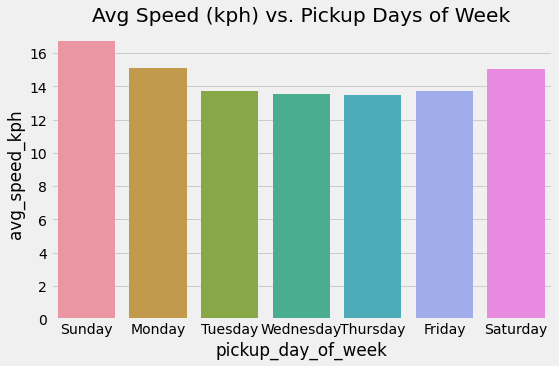

In [41]:
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    'pickup_day_of_week', 'avg_speed_kph', data=avg_speed_per_day,
    order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
)
plt.title('Avg Speed (kph) vs. Pickup Days of Week')
plt.show()

평균 속도는 일요일가 월요일이 가장 높습니다.

### Feature Engineering on Test Data

In [42]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_day_of_week'] = test['pickup_datetime'].apply(lambda x: calendar.day_name[x.weekday()])

test['pickup_latitude_round3'] = round(test['pickup_latitude'], 3)
test['pickup_longitude_round3'] = round(test['pickup_longitude'], 3)
test['dropoff_latitude_round3'] = round(test['dropoff_latitude'], 3)
test['dropoff_longitude_round3'] = round(test['dropoff_longitude'], 3)
test['trip_distance'] = test.apply(lambda x: calculateDistance(x), axis=1)
test['bearing'] = calculateBearing(test['pickup_latitude_round3'], test['pickup_longitude_round3'], test['dropoff_latitude_round3'], test['dropoff_longitude_round3'])
test['pickup_neighborhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_neighborhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### Building Models
트레이닝 데이터에서 dropoff 관련 feature들은 제거해야 합니다. lat, lon feature들은 반올림한 값을 사용합니다.

In [43]:
drop_cols=[
    'avg_speed_kph', 'trip_duration_in_hour', 'dropoff_date', 'dropoff_day',
    'dropoff_hour', 'dropoff_day_of_week', 'dropoff_datetime', 'pickup_latitude',
    'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
]
test_id=test['id']
training = train.drop(drop_cols, axis=1)
testing = test.drop(drop_cols[-4:], axis=1)

trip_duration을 예측해야 하므로 이 값을 log 범위로 바꾸어 예측하겠습니다.

In [44]:
training['log_trip_duration'] = np.log(training['trip_duration'])
training.drop('trip_duration', axis=1, inplace=True)

In [45]:
print('Training Data Shape', training.shape)
print('Testing Data Shape', testing.shape)

Training Data Shape (1458644, 18)
Testing Data Shape (625134, 17)


day of week 값들은 숫자로 인코딩하겠습니다.

In [46]:
def encodeDays(day_of_week):
    day_dict={
        'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3,
        'Thursday':4, 'Friday':5, 'Saturday':6
    }
    return day_dict[day_of_week]

In [47]:
training['pickup_day_of_week'] = training['pickup_day_of_week'].apply(lambda x: encodeDays(x))
testing['pickup_day_of_week'] = testing['pickup_day_of_week'].apply(lambda x: encodeDays(x))

In [48]:
training.to_csv('data/input_training.csv', index=False)
testing.to_csv('data/input_testing.csv', index=False)
del training
del testing
del train
del test

In [49]:
def LabelEncoding(train_df, test_df, max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col] = le.transform(train_df[col])
                test_df[col] = le.transform(test_df[col])
    return [train_df, test_df]

In [50]:
def readInputAndEncode(input_path, train_file, test_file, target_column):
    training = pd.read_csv(input_path + train_file)
    testing = pd.read_csv(input_path + test_file)
    training, testing = LabelEncoding(training, testing)
    train_cols = training.columns.tolist()
    test_cols = testing.columns.tolist()
    col_in_train_not_test = set(train_cols) - set(test_cols)
    for col in col_in_train_not_test:
        if col != target_column:
            testing[col] = 0
    col_in_test_not_train = set(test_cols) - set(train_cols)
    for col in col_in_test_not_train:
        training[col] = 0
    print('Training Data Shape after Processing', training.shape)
    print('Testing Data Shape after Processing', testing.shape)
    return [training, testing]

In [51]:
train, test = readInputAndEncode('data/', 'input_training.csv', 'input_testing.csv', 'log_trip_duration')
train.drop(['pickup_date', 'pickup_datetime', 'id'], axis=1, inplace=True)
test.drop(['pickup_date', 'pickup_datetime', 'id'], axis=1, inplace=True)

Training Data Shape after Processing (1458644, 18)
Testing Data Shape after Processing (625134, 17)


In [52]:
def GetFeaturesAndSplit(train, test, target, imputing_strategy='median',
                        split=0.25, imputation=True):
    labels = np.array(train[target])
    training = train.drop(target, axis=1)
    testing = np.array(test)
    if imputation == True:
        imputer = SimpleImputer(strategy=imputing_strategy, missing_values=np.nan)
        imputer.fit(training)
        training = imputer.transform(training)
        testing = imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size=split, random_state=42)
    return [train_features, validation_features, train_labels, validation_labels, testing]

In [53]:
train_features, validation_features, train_labels, validation_labels, testing = GetFeaturesAndSplit(train, test, 'log_trip_duration', imputation=False)

#### Apply Linear Regression

In [54]:
lm = linear_model.LinearRegression()
lm.fit(train_features, train_labels)

LinearRegression()

In [55]:
valid_pred = lm.predict(validation_features)

In [56]:
rmse = mean_squared_error(validation_labels, valid_pred)
print('Root Mean Squared Error for Linear Regression(log scale)', rmse)

Root Mean Squared Error for Linear Regression(log scale) 0.40034743019597596


In [57]:
test_pred = lm.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('data/submission_3_linear_regression_baseline.csv', index=False)
del submit

#### Apply Random Forest Regressor

In [58]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [59]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=42)

In [60]:
valid_pred_rf = rf.predict(validation_features)
rmse = mean_squared_error(validation_labels, valid_pred_rf)
print('Root Mean Squared Error for Random Forest', rmse)

Root Mean Squared Error for Random Forest 0.16592869728414253


In [61]:
test_pred = rf.predict(testing)
submit = pd.DataFrame()
submit['id'] = test_id
submit['trip_duration'] = np.exp(test_pred)
submit.to_csv('data/submission_3_random_forest_baseline.csv', index=False)